In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import os
import re
import json

In [2]:
if not os.path.isdir('results'):
    os.system('tar xf z1_distributed.tar.gz')

In [3]:
root_path='results/zillow/Z1/'
paths = sorted(list(map(lambda p: os.path.join(root_path, p), os.listdir(root_path))))

In [6]:
!ls results/zillow/Z1/

aws-emr-run-1.log.txt                tuplex-compiled-4x-run-11.log.txt
aws-emr-run-1.txt                    tuplex-compiled-4x-run-11.txt
aws-emr-run-1.txt.stderr             tuplex-compiled-4x-run-11.txt.stderr
aws-emr-run-10.log.txt               tuplex-compiled-4x-run-2.log.txt
aws-emr-run-10.txt                   tuplex-compiled-4x-run-2.txt
aws-emr-run-10.txt.stderr            tuplex-compiled-4x-run-2.txt.stderr
aws-emr-run-11.log.txt               tuplex-compiled-4x-run-3.log.txt
aws-emr-run-11.txt                   tuplex-compiled-4x-run-3.txt
aws-emr-run-11.txt.stderr            tuplex-compiled-4x-run-3.txt.stderr
aws-emr-run-2.log.txt                tuplex-compiled-4x-run-4.log.txt
aws-emr-run-2.txt                    tuplex-compiled-4x-run-4.txt
aws-emr-run-2.txt.stderr             tuplex-compiled-4x-run-4.txt.stderr
aws-emr-run-3.log.txt                tuplex-compiled-4x-run-5.log.txt
aws-emr-run-3.txt                    tuplex-compiled-4x-run-5.txt
aws-emr-run-3.txt.stderr 

In [8]:
rows = []

for path in paths:
    try:
        if 'aws-emr' in path and path.endswith('txt.stderr'):
            line = open(path, 'r').readlines()[-2]

            m = re.search(r'run-(\d+)', path)
            run = int(m[1])

            m = re.search(r'(\d+.\d+)s', line)
            job_time = float(m[1])

            rows.append({'framework' : 'aws-emr', 'threads' : 4, 'job_time' : job_time, 'run': run})

        elif 'pywren' in path and path.endswith('.txt'):
            data = json.load(open(path, 'r'))

            m = re.search(r'run-(\d+)', path)
            run = int(m[1])

            job_time = data['job_time']

            rows.append({'framework' : 'pywren', 'threads' : 1, 'job_time' : job_time, 'run': run})
        elif 'tuplex' in path and path.endswith('txt.stderr'):
            if 'x-' not in path:
                continue
            
            # extract name -> tuplex-compiled or tuplex-interpreted
            fw = 'tuplex-compiled' if 'tuplex-compiled' in path else 'tuplex-interpreted'

            line = list(filter(lambda line: '"jobTime":' in line, open(path, 'r').readlines()))[0]
            line = line[line.find('{'):]
            data = json.loads(line)
            
            thread_count = 1
            if fw == 'tuplex-compiled':
                m = re.search(r'-(\d+)x-', path)
                thread_count = int(m[1])
        

            m = re.search(r'run-(\d+)', path)
            run = int(m[1])
            
            job_time = data['jobTime']

            rows.append({'framework' : fw, 'threads' : thread_count, 'job_time' : job_time, 'run': run})
    except Exception as e:
        print('>>> bad file: ' + path)


>>> bad file: results/zillow/Z1/aws-emr-run-9.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-1.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-10.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-11.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-2.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-3.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-4.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-5.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-6.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-7.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-8.txt.stderr
>>> bad file: results/zillow/Z1/tuplex-compiled-run-9.txt.stderr


In [9]:
df = pd.DataFrame(rows).sort_values(by='job_time').reset_index(drop=True)

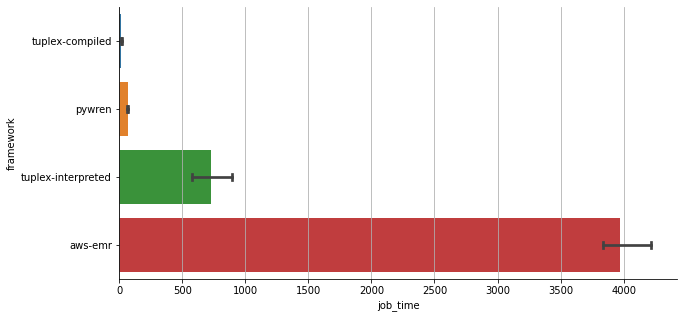

In [10]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, y='framework', x = 'job_time', capsize=.1)
#sns.boxplot(data=df, x='framework', y = 'job_time')
# plt.yscale('log')
plt.grid(axis='x')
sns.despine()

In [11]:
df.to_csv('zillow_Z1_distributed.csv', index=None)

In [19]:
gdf = df[['framework', 'job_time', 'threads']].groupby(['framework', 'threads']).describe().sort_values(by=('job_time', 'mean'))
gdf

job_time                                        \
                              count         mean         std          min   
framework          threads                                                  
tuplex-compiled    2           11.0     8.179438    3.116980     5.751138   
                   4           11.0    16.432568    1.906592    14.316047   
                   6           11.0    23.561224    4.571673    19.644575   
                   1           11.0    24.042530    6.711679    20.003647   
pywren             1           11.0    68.511083    6.482510    63.548484   
tuplex-interpreted 1           11.0   728.394932  283.467165   363.383731   
aws-emr            4           10.0  3972.866671  364.216276  3751.066321   

                                                                                
                                    25%          50%          75%          max  
framework          threads                                                      
tuplex-compiled    2           6.256087     6.910912     9.085455    15.891790  
                   4          15.188200    15.440103    17.768164    20.200642  
                   6          20.404099    22.188736    24.635410    35.161015  
                   1          20.251290    21.105683    24.012941    42.294787  
pywren             1          65.613988    65.802774    66.391986    81.541633  
tuplex-interpreted 1         576.344713   692.594272   758.291702  1302.954115  
aws-emr            4        3820.890856  3894.968917  3901.943772  4995.993513

In [20]:
latex = gdf[[('job_time', 'mean'), ('job_time', 'std'), ('job_time', 'min'), ('job_time', 'max')]].to_latex(float_format="%.2f")

In [21]:
print(latex)

\begin{tabular}{llrrrr}
\toprule
        &   & \multicolumn{4}{l}{job\_time} \\
        &   &     mean &    std &     min &     max \\
framework & threads &          &        &         &         \\
\midrule
tuplex-compiled & 2 &     8.18 &   3.12 &    5.75 &   15.89 \\
        & 4 &    16.43 &   1.91 &   14.32 &   20.20 \\
        & 6 &    23.56 &   4.57 &   19.64 &   35.16 \\
        & 1 &    24.04 &   6.71 &   20.00 &   42.29 \\
pywren & 1 &    68.51 &   6.48 &   63.55 &   81.54 \\
tuplex-interpreted & 1 &   728.39 & 283.47 &  363.38 & 1302.95 \\
aws-emr & 4 &  3972.87 & 364.22 & 3751.07 & 4995.99 \\
\bottomrule
\end{tabular}

